In [1]:
import numpy as np
import pandas as pd
import pyampute
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, LinearRegression

import statsmodels.api as sm

# Function (all together)

In [2]:
def rubins_pooling_rules(m_coefs, m_vars_coefs):
    """Applies Rubin's pooling rules.
    The final weights is defined as the mean of the weights across the imputed
    datasets while the total variance is defined as the combination of the mean
    of the variance of the weights and the variance of the coefficients.
    Parameters
    ----------
    m_coefs : ndarray, shape (n_imputations, n_features)
        The weights of the model fitted on each imputed dataset.
    m_vars_coefs : ndarray, shape (n_imputations, n_features)
        An estimate of the variance of the weights on each imputed dataset.
    Returns
    -------
    mean_coefs : ndarray, shape (n_features,)
        The mean coefficients computed across the imputed datasets.
    total_var_coefs : ndarray, shape (n_features,)
        An estimate of the total variation of the weights across the imputed
        datasets.
    """
    mean_coefs = np.mean(m_coefs, axis=0)
    mean_vars_coefs = np.mean(m_vars_coefs, axis=0)
    vars_coefs = np.var(m_coefs, axis=0, ddof=1)
    total_var_coefs = mean_vars_coefs + (1 + 1 / vars_coefs.shape[0]) * vars_coefs
    return mean_coefs, total_var_coefs


In [100]:
def coefs_vars(df):
    X = sm.add_constant(df.iloc[:, 0:3])
    ols = sm.OLS(df.iloc[:,3], X)
    ols_result = ols.fit()
    
    coefss = ols_result.params
    varss = ols_result.bse
    return coefss, varss

In [101]:
n = 300
def dataset(n = 300, mu = np.array([5, 5, 5, 5]), ro = 0.1):

    Sigma = np.array([[1, ro, ro, ro], 
                      [ro, 1, ro, ro], 
                      [ro, ro, 1, ro], 
                      [ro, ro, ro, 1]])
    X_cont = np.random.multivariate_normal(mu, Sigma, size = n)

    X = pd.DataFrame(X_cont, columns = ['X1', 'X2', 'X3', 'Y1'])
    
    return X

In [210]:
X.shape[0]

300

In [195]:
df1 = dataset(mu = np.array([2, 2, 2, 3]), ro = 0.2, n = int(n/2))

df2 = dataset(mu = np.array([1, 1, 1, 6]), ro = -1, n = int(n/2))


/var/folders/92/dcftn9sd2dd2p4k6tn1p2plc0000gn/T/ipykernel_29889/996536265.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  X_cont = np.random.multivariate_normal(mu, Sigma, size = n)


In [196]:
df = pd.concat([df1, df2])

In [198]:
X = sm.add_constant(df.iloc[:, 0:3])
ols = sm.OLS(df.iloc[:,3], X)
ols_result = ols.fit()
ols_result.conf_int(alpha=0.05, cols=None)

,0,1
const,5.482598,6.201542
X1,-0.548037,-0.258797
X2,-0.363139,-0.061068
X3,-0.481987,-0.163504


In [214]:
ols_result.params

const    5.842070
X1      -0.403417
X2      -0.212103
X3      -0.322746
dtype: float64

In [204]:
(ols_result.conf_int(alpha=0.05, cols=None)[1] - ols_result.conf_int(alpha=0.05, cols=None)[0])/2

const    0.359472
X1       0.144620
X2       0.151035
X3       0.159242
dtype: float64

In [205]:
ols_result.bse

const    0.182657
X1       0.073485
X2       0.076745
X3       0.080915
dtype: float64

In [171]:
df_coef, df_var = coefs_vars(df)

In [172]:
df_coef

const    5.585558
X1      -0.025151
X2      -0.040094
X3      -0.028291
dtype: float64

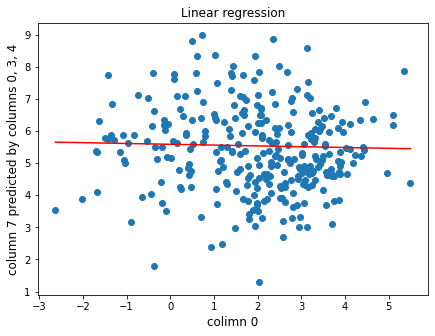

In [173]:
#Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(df.iloc[:,1], df.iloc[:,3])
# tt0 = np.linspace(min(df.iloc[:,0]), max(df.iloc[:,0]), n)
tt = np.linspace(min(df.iloc[:,1]), max(df.iloc[:,1]), n)
# tt2 = np.linspace(min(df.iloc[:,2]), max(df.iloc[:,2]), n)
plt.plot(tt, lin_func(tt, df_coef), c='r')
#On ajoute les titres des axes
plt.xlabel("colimn 0", fontsize = 12)
plt.ylabel("column 7 predicted by columns 0, 3, 4", fontsize = 12)
plt.title("Linear regression")

plt.show()

In [174]:
def ampute(df, pat):
    pr = prop

    ma = MultivariateAmputation(
            patterns = pat,
            prop = pr
        )
    X_miss = ma.fit_transform(df)  
    return X_miss

In [175]:
prop = 0.5
df_miss2 = ampute(df2, pat = [{'incomplete_vars': [0, 2], 'mechanism': "MNAR", 'weights': [0, 1, 0, 1]},
                           {'incomplete_vars': [1], 'mechanism': "MNAR", 'weights': [1, 1, 0, 0]}])

2022-10-30 15:22:00,236 [WARNING] Indicated weights for vars that are observed for a pattern with MNAR. Did you mean MAR+MNAR?


In [176]:
df_miss2

,X1,X2,X3,Y1
0,2.219643,NaN,-0.607499,7.111731
1,NaN,3.156817,NaN,5.877580
2,3.658373,0.522887,-0.072254,5.583156
3,NaN,2.039964,NaN,7.838615
4,-0.354530,2.030985,3.252697,4.526536
...,...,...,...,...
145,1.075116,1.802958,-0.655966,3.258526
146,0.148859,2.327851,0.931443,5.612521
147,0.269359,-0.187199,1.180276,5.486907
148,-1.626208,2.073882,0.327239,6.694866


In [177]:
df_CC2 = df_miss2.copy()
df_CC2.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df_CC2

,X1,X2,X3,Y1
2,3.658373,0.522887,-0.072254,5.583156
4,-0.354530,2.030985,3.252697,4.526536
6,1.824276,0.152259,0.297261,5.636830
9,2.531052,-1.433017,-1.183174,7.739709
10,0.110089,-1.690819,2.470548,5.388273
...,...,...,...,...
145,1.075116,1.802958,-0.655966,3.258526
146,0.148859,2.327851,0.931443,5.612521
147,0.269359,-0.187199,1.180276,5.486907
148,-1.626208,2.073882,0.327239,6.694866


In [178]:
df_CC0 = pd.concat([df1, df_CC2])

In [179]:
df_CC_coef, df_CC_var = coefs_vars(df_CC0)

In [180]:
df_coef

const    5.585558
X1      -0.025151
X2      -0.040094
X3      -0.028291
dtype: float64

In [181]:
df_CC_coef

const    5.248594
X1      -0.013522
X2      -0.063599
X3       0.064362
dtype: float64

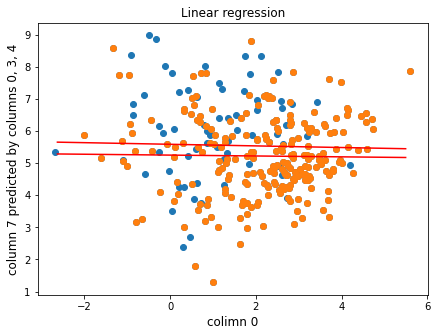

In [182]:
#Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(df.iloc[:,2], df.iloc[:,3])
plt.scatter(df_CC0.iloc[:,2], df_CC0.iloc[:,3])
# tt0 = np.linspace(min(df.iloc[:,0]), max(df.iloc[:,0]), n)
tt = np.linspace(min(df.iloc[:,1]), max(df.iloc[:,1]), n)
# tt2 = np.linspace(min(df.iloc[:,2]), max(df.iloc[:,2]), n)
plt.plot(tt, lin_func(tt, df_coef), c='r')
plt.plot(tt, lin_func(tt, df_CC_coef), c='r')

#On ajoute les titres des axes
plt.xlabel("colimn 0", fontsize = 12)
plt.ylabel("column 7 predicted by columns 0, 3, 4", fontsize = 12)
plt.title("Linear regression")

plt.show()

In [183]:
# #Scatter plot
# plt.figure(figsize=(7,5))
# plt.scatter(df.iloc[:,2], df.iloc[:,3])
# plt.scatter(df_CC0.iloc[:,2], df_CC0.iloc[:,3])

# tt0 = np.linspace(min(df_CC0.iloc[:,0]), max(df_CC0.iloc[:,0]), 1000)
# tt1 = np.linspace(min(df_CC0.iloc[:,1]), max(df_CC0.iloc[:,1]), 1000)
# tt2 = np.linspace(min(df_CC0.iloc[:,2]), max(df_CC0.iloc[:,2]), 1000)
# plt.plot(tt0, df_coef[0] * tt0 + df_coef[1] * tt1 + df_coef[2] * tt2, c='r')
# plt.plot(tt0, df_CC_coef[0] * tt0 + df_CC_coef[1] * tt1 + df_CC_coef[2] * tt2, c='r')
# #On ajoute les titres des axes
# plt.xlabel("colimn 0", fontsize = 12)
# plt.ylabel("column 7 predicted by columns 0, 3, 4", fontsize = 12)
# plt.title("Linear regression")

# plt.show()

In [184]:
df_misss = pd.concat([df1, df_miss2])

In [185]:
imp_mi = mice(df_misss)
mice_df = np.array(imp_mi).mean(axis=0)
mice_df = pd.DataFrame(mice_df)
mi_coef, mi_vars = pooling(imp_mi)

In [213]:
imp_mi[0].shape[0]

300

In [186]:
mice_df

,0,1,2,3
0,2.575850,3.757042,2.789331,3.806449
1,2.202036,3.091276,2.881108,4.476132
2,1.199214,1.522316,1.114920,4.731153
3,1.239792,3.157415,2.689602,4.246505
4,3.953090,4.373604,3.466819,5.205462
...,...,...,...,...
295,1.075116,1.802958,-0.655966,3.258526
296,0.148859,2.327851,0.931443,5.612521
297,0.269359,-0.187199,1.180276,5.486907
298,-1.626208,2.073882,0.327239,6.694866


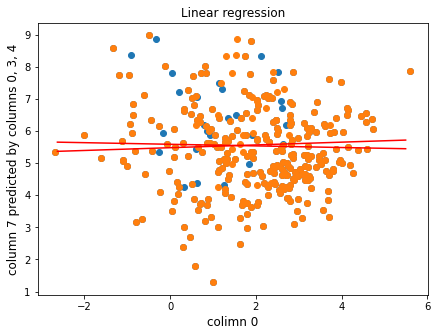

In [187]:
#Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(df.iloc[:,2], df.iloc[:,3])
plt.scatter(mice_df.iloc[:,2], mice_df.iloc[:,3])
tt = np.linspace(min(df.iloc[:,1]), max(df.iloc[:,1]), n)
plt.plot(tt, lin_func(tt, df_coef), c='r')
plt.plot(tt, lin_func(tt, mi_coef), c='r')
# plt.plot(tt0, mi_coef[0] * tt0 + mi_coef[1] * tt1 + mi_coef[2] * tt2, c='r')
#On ajoute les titres des axes
plt.xlabel("colimn 0", fontsize = 12)
plt.ylabel("column 7 predicted by columns 0, 3, 4", fontsize = 12)
plt.title("Linear regression")

plt.show()

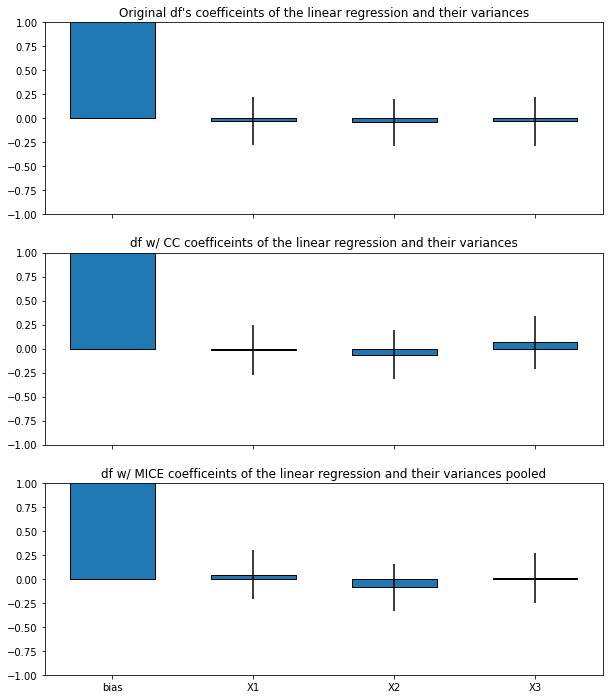

In [194]:
plott(df_coef, df_var, df_CC_coef, df_CC_var, mi_coef, mi_vars)

In [189]:
def mice(X_miss):
    n_imputations = 10
    imp_mice = []

    for i in range(n_imputations):
        imp = IterativeImputer(max_iter = 50, random_state = i, sample_posterior = True, estimator = BayesianRidge()).fit_transform(X_miss)
        imp = pd.DataFrame(imp)
        imp_mice.append(imp)
        
    
    return imp_mice

In [32]:
def pooling(imp_mice):
    m_coefs = []
    m_vars = []
    
    for imp in imp_mice:
        
        mice_coefs, mice_vars = coefs_vars(pd.DataFrame(imp))

        m_coefs.append(mice_coefs)
        m_vars.append(mice_vars)

    m_coefs = np.array(m_coefs)
    m_vars = np.array(m_vars)
    
    
    mice_means = rubins_pooling_rules(m_coefs, m_vars)[0]
    mice_varis = rubins_pooling_rules(m_coefs, m_vars)[1]
    return mice_means, mice_varis

In [193]:
def plott(df_coefs, df_vars, CC_coef, CC_vars, mice_coef, mice_vars):
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    ax[0].bar(x= ['bias', 'X1', 'X2', 'X3'], 
           height= df_coefs, 
           width=0.6, 
           yerr = np.sqrt(df_vars), 
           alpha=1,  
           edgecolor='black')
    ax[0].set_title("Original df's coefficeints of the linear regression and their variances")

    ax[1].bar(x= ['bias', 'X1', 'X2', 'X3'], 
           height= CC_coef, 
           width=0.6, 
           yerr = np.sqrt(CC_vars), 
           alpha=1,  
           edgecolor='black')
    ax[1].set_title("df w/ CC coefficeints of the linear regression and their variances")

    ax[2].bar(x= ['bias', 'X1', 'X2', 'X3'], 
           height= mice_coef, 
           width=0.6, 
           yerr = np.sqrt(mice_vars), 
           alpha=1,  
           edgecolor='black')
    ax[2].set_title("df w/ MICE coefficeints of the linear regression and their variances pooled")
    
    {ax_i.set_ylim(-1,1) for ax_i in ax}

In [773]:
def coeff(pat):
    df_cont = dataset()
    
    df_coefs, df_vars = coefs_vars(df_cont)

    X_miss = ampute(df_cont, pat)
    
    df_CC = X_miss.copy()
    df_CC.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    CC_coef, CC_vars = coefs_vars(df_CC)
    
    imp_mice = mice(X_miss)
    mice_coef, mice_vars = pooling(imp_mice)

    plott(df_coefs, df_vars, CC_coef, CC_vars, mice_coef, mice_vars)

## MAR [0,1]; [1,2]

### pr = 0.2

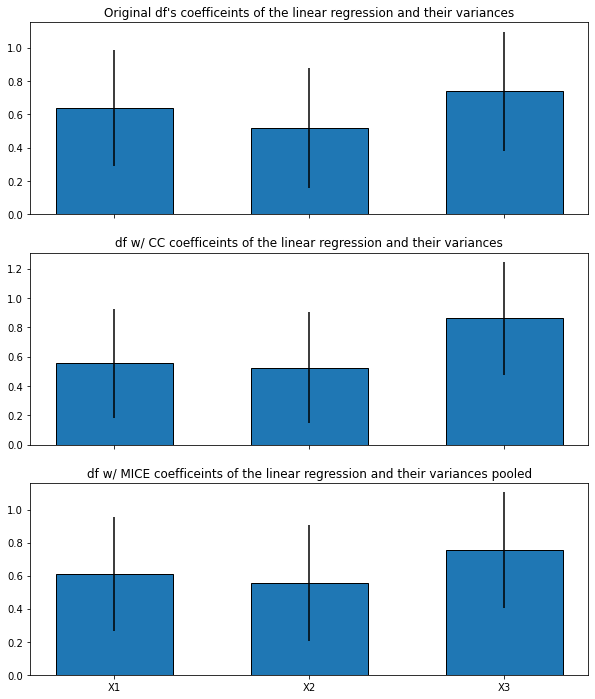

In [43]:
prop = 0.2
coeff(pat = [{'incomplete_vars': [2], 'mechanism': "MNAR"}])

In [ ]:
# #Scatter plot
# plt.figure(figsize=(7,5))
# plt.scatter(df.iloc[:,1], df.iloc[:,3])
# tt0 = np.linspace(min(df.iloc[:,0]), max(df.iloc[:,0]), n)
# tt1 = np.linspace(min(df.iloc[:,1]), max(df.iloc[:,1]), n)
# tt2 = np.linspace(min(df.iloc[:,2]), max(df.iloc[:,2]), n)
# plt.plot(tt0, df_coef[0] * tt0 + df_coef[1] * tt1 + df_coef[2] * tt2, c='r')
# #On ajoute les titres des axes
# plt.xlabel("colimn 0", fontsize = 12)
# plt.ylabel("column 7 predicted by columns 0, 3, 4", fontsize = 12)
# plt.title("Linear regression")

# plt.show()